In [14]:
import os                   # to interact with the operating system
import glob

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Compute NAO

**Hurrell North Atlantic Oscillation (NAO) Index (PC-based)**

The principal component (PC)-based indices of the North Atlantic Oscillation (NAO) are the time series of the leading Empirical Orthogonal Function (EOF) of SLP anomalies over the Atlantic sector, 20°-80°N, 90°W-40°E. 

https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based

**Dealing with zero meridian**

the longitudinal slice I am interesed in is slpit by the 0 meridian. This means we have two slices, 0-30 and 215-288 respectively. By rolling minus 20 lon I can move them into one consecutive slice. the resulting slice will be: (215-30) - 288

In [79]:
def compute_NAO(file_path):
    psl_ds = xr.open_dataset(file_path).roll(lon=-30).isel(lat=slice(120, 180), lon=slice(215-30, 288))

    shape = psl_ds['PSL'].shape
    data = psl_ds['PSL'].values.reshape(shape[0], -1)

    data = psl_ds.PSL.values
    weights = psl_ds.gw.values
    weights = weights[np.newaxis, :,  np.newaxis]

    # spatial weighting and reshpaing
    weighted_data = data * weights
    shape = weighted_data.shape
    data_2d = weighted_data.reshape(shape[0], -1)

    # mean per time step
    mean_per_time_step = np.nanmean(data_2d, axis=1)
    nan_indices = np.isnan(data_2d)
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])

    # center data
    mean = np.mean(data_2d[0:1500], axis=0)
    centered_data = data_2d - mean

    # eigenvalue decomposition
    cov_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # determine pcs
    first_principal_component = np.dot(centered_data, eigenvectors[:, 0])
    first_principal_component = first_principal_component[:-1]

    second_principal_component = np.dot(centered_data, eigenvectors[:, 1])
    second_principal_component = second_principal_component[:-1]

    # Determine sign of pcs
    row_start1, row_end1 = 35, 45
    col_start1, col_end1 = 40, 55

    eof1 = eigenvectors[:, 0].reshape(psl_ds.dims['lat'], psl_ds.dims['lon'])
    if np.mean(eof1[row_start1:row_end1+1, col_start1:col_end1+1]) < 0:
        first_principal_component = -first_principal_component

    eof2 = eigenvectors[:, 1].reshape(psl_ds.dims['lat'], psl_ds.dims['lon'])
    if np.mean(eof2[row_start1:row_end1+1, col_start1:col_end1+1]) < 0:
        second_principal_component = -second_principal_component

    return first_principal_component, second_principal_component

In [80]:
file_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1301.019.nc'
nao, eap = compute_NAO(file_path)

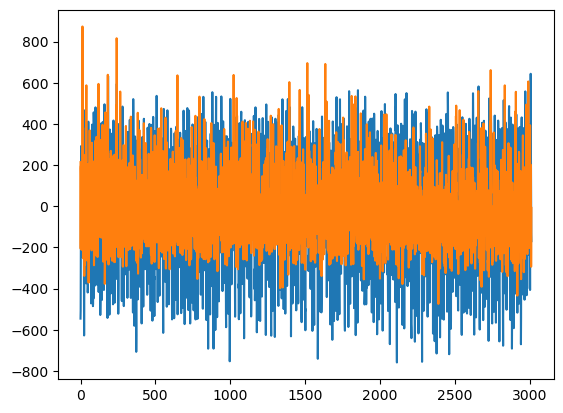

In [81]:
plt.plot(nao)
plt.plot(eap)

# Normalise NAO

In [82]:
psl_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_*.nc'))

In [89]:
# append all pcs if all psl files
all_first_pcs = []
all_second_pcs = []
for file_path in psl_files[:3]:
    first_pc, second_pc = compute_NAO(file_path)
    all_first_pcs.append(first_pc)
    all_second_pcs.append(second_pc)

In [90]:
# computing statistics of first pcs
combined_first_pcs = np.concatenate(all_first_pcs)
mean_nao = np.mean(combined_first_pcs)
std_nao = np.std(combined_first_pcs)
# computing statistics of fzsecond pcs
combined_second_pcs = np.concatenate(all_second_pcs)
mean_eap = np.mean(combined_second_pcs)
std_eap = np.std(combined_second_pcs)

# Normalise both patterns
normalised_first_pcs = []
normalised_second_pcs = []
for nao, eap in zip(all_first_pcs, all_second_pcs):
    normalised_nao = (nao - mean_nao) / std_nao
    normalised_eap = (eap - mean_eap) / std_eap
    normalised_first_pcs.append(normalised_nao)
    normalised_second_pcs.append(normalised_eap)

# Compute integrated NAO

In [91]:
window_size = 10 * 12  # 10 years

def calculate_moving_average(standardised_pcs):
    moving_averages = []
    for pcs in standardised_pcs:
        moving_avg = np.convolve(pcs, np.ones(window_size)/window_size, mode='valid')
        pad_width = (window_size - 1) // 2
        padded_moving_avg = np.pad(moving_avg, (pad_width, len(pcs) - len(moving_avg) - pad_width), mode='constant')
        moving_averages.append(padded_moving_avg)
    return moving_averages

In [92]:
nao_int = calculate_moving_average(normalised_first_pcs)
eap_int = calculate_moving_average(normalised_second_pcs)

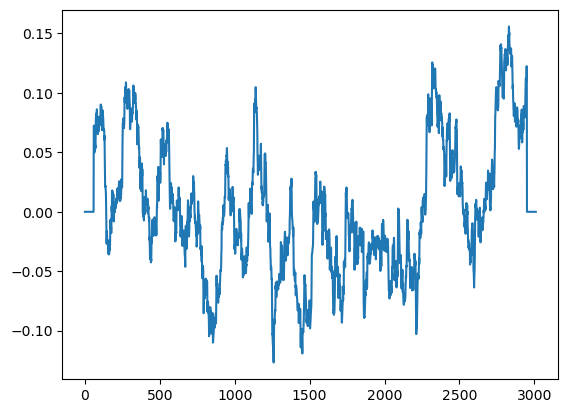

In [96]:
plt.plot(nao_int[0])

# **Explanation for determination of sign**

If the pressure anomaly pattern resembles the typical positive phase of the NAO (i.e., higher pressure over the Azores and lower pressure over Iceland), then positive values of the associated time series correspond to the positive phase of the NAO, and negative values correspond to the negative phase. Conversely, if the pattern is reversed, the interpretation of the sign is also reversed.

**Explanation for two regions**

If I should ever want to compute the NAO via a different metric, this is the way to start.

In [75]:
# Define Iceland Region
row_start1, row_end1 = 35, 45
col_start1, col_end1 = 40, 55

# Define Azores Region
row_start2, row_end2 = 15, 25
col_start2, col_end2 = 40, 55

# Extract sub-arrays for each region
region1 = eof1[row_start1:row_end1+1, col_start1:col_end1+1]
region2 = eof1[row_start2:row_end2+1, col_start2:col_end2+1]

# Calculate the averages of the two regions
average_region1 = np.mean(region1)
average_region2 = np.mean(region2)

# Compute the difference between the two averages
difference = average_region1 - average_region2

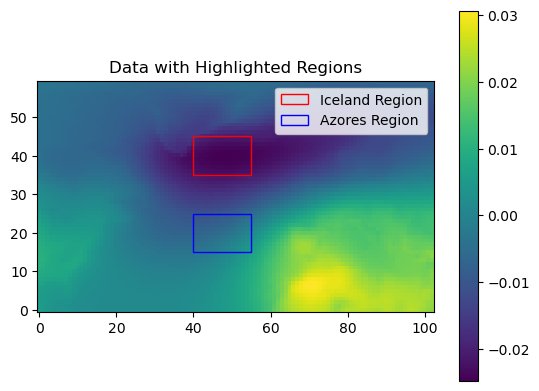

In [70]:
# Plot the data
plt.imshow(eof1, cmap='viridis', origin='lower')
plt.title('Data with Highlighted Regions')

# Create rectangles for each region and add to plot
rect1 = patches.Rectangle((col_start1, row_start1), col_end1 - col_start1, 
                          row_end1 - row_start1, linewidth=1, edgecolor='r', 
                          facecolor='none', label='Iceland Region')
rect2 = patches.Rectangle((col_start2, row_start2), col_end2 - col_start2, 
                          row_end2 - row_start2, linewidth=1, edgecolor='blue', 
                          facecolor='none', label='Azores Region')

# Add patches to the axes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)

# Add legend to distinguish regions
plt.legend()
plt.colorbar()

# Show the plot
plt.show()